In [1]:
import os
import re
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
from optuna.storages import RDBStorage

from sklearn.linear_model import LinearRegression

In [2]:
study_dir = '/mnt/nas/optuna_studies/optuna_viktor.db'

font_size = 16

In [3]:
storage = RDBStorage(url=f"sqlite:///{study_dir}")
study_summaries = optuna.get_all_study_summaries(storage=storage)
study_names = [summary.study_name for summary in study_summaries]
studies = [optuna.load_study(study_name=study_name, storage=f"sqlite:///{study_dir}") for study_name in study_names]
entries = []
for study in studies:
    completed_trials = [trial for trial in study.trials if trial.value is not None and trial.state == optuna.trial.TrialState.COMPLETE]
    pruned_trials = [trial for trial in study.trials if trial.state == optuna.trial.TrialState.PRUNED]
    study_name = study.study_name
    study_setting = study_name[0:2]
    model_match = re.search(r'_m-([^_]+)', study_name)
    model_type = model_match.group(1) if model_match else None
    out_match = re.search(r'_out-([^_]+)', study_name)
    out_type = out_match.group(1) if out_match else None
    freq_match = re.search(r'_freq-([^_]+)', study_name)
    freq_type = freq_match.group(1) if freq_match else None
    additional = None
    try:
        best_value = study.best_trial.value
    except ValueError:
        best_value = None
    if len(study_name.split('_')) > 4:
        additional = study_name.split('_')[-1]
    entry = {
        'study_name': study.study_name,
        'model': model_type,
        'setting': study_setting,
        'add': additional,
        'n_trials': len(study.trials),
        'n_compl_trials': len(completed_trials),
        'n_pruned_trials': len(pruned_trials),
        'best_value': round(best_value, 4) if best_value is not None else None,
    }
    entries.append(entry)
results = pd.DataFrame(entries)
#results_styled = results.style.set_properties(subset=['study_name'], **{'text-align': 'left'})
results

,study_name,model,setting,add,n_trials,n_compl_trials,n_pruned_trials,best_value
0,cl_m-tft_out-48_freq-1h_wind_50,tft,cl,50,310,282,0,0.1154
1,cl_m-tft_out-48_freq-1h_wind_00198.yaml,tft,cl,00198.yaml,1691,60,1629,0.1456
2,cl_m-tft_out-48_freq-1h_wind_00164.yaml,tft,cl,00164.yaml,373,100,273,0.0704
3,cl_m-tft_out-48_freq-1h_wind_00183.yaml,tft,cl,00183.yaml,202,100,102,0.1838
4,cl_m-tft_out-48_freq-1h_wind_00232.yaml,tft,cl,00232.yaml,118,100,18,0.0814
...,...,...,...,...,...,...,...,...
93,cl_m-tft_out-48_freq-1h_wind_05906.yaml,tft,cl,05906.yaml,8,7,0,0.0396
94,cl_m-tft_out-48_freq-1h_wind_13674.yaml,tft,cl,13674.yaml,4,3,0,0.1037
95,cl_m-tft_out-48_freq-1h_wind_05930.yaml,tft,cl,05930.yaml,2,1,0,0.2025
96,cl_m-tft_out-48_freq-1h_wind_06163.yaml,tft,cl,06163.yaml,103,100,3,0.0921


In [5]:
results.loc[results.n_trials < 100]

,study_name,model,setting,add,n_trials,n_compl_trials,n_pruned_trials,best_value
13,cl_m-tft_out-48_freq-1h_wind_00880.yaml,tft,cl,00880.yaml,93,65,25,0.0304
14,cl_m-tft_out-48_freq-1h_wind_00460.yaml,tft,cl,00460.yaml,39,36,0,0.1728
15,cl_m-tft_out-48_freq-1h_wind_00591.yaml,tft,cl,00591.yaml,63,53,8,0.0497
43,cl_m-tft_out-48_freq-1h_wind_02564.yaml,tft,cl,02564.yaml,72,69,2,0.1254
73,cl_m-tft_out-48_freq-1h_wind_05516.yaml,tft,cl,05516.yaml,95,18,75,0.2057
74,cl_m-tft_out-48_freq-1h_wind_05546.yaml,tft,cl,05546.yaml,14,13,0,0.1044
86,cl_m-tft_out-48_freq-1h_wind_07374.yaml,tft,cl,07374.yaml,44,16,27,0.0594
90,cl_m-tft_out-48_freq-1h_wind_07410.yaml,tft,cl,07410.yaml,74,17,56,0.1578
91,cl_m-tft_out-48_freq-1h_wind_05779.yaml,tft,cl,05779.yaml,38,21,16,0.1537
92,cl_m-tft_out-48_freq-1h_wind_07412.yaml,tft,cl,07412.yaml,12,11,0,0.1233


In [ ]:
study = study_summaries[10].study_name
#optuna.delete_study(study_name=study, storage=f"sqlite:///{study_dir}")

### Best Trial

In [5]:
for study in study_summaries:
    print(f'Best trial of {study.study_name}')
    trial = study.best_trial
    if not trial:
        print('No best trial for this.')
        continue
    print(f'  Error: {trial.value}')
    print('  Params: ')
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
    print()

Best trial of cl_m-tft_out-48_freq-1h_wind_100
  Error: 0.05186625414838394
  Params: 
    batch_size: 339
    epochs: 119
    lr: 0.0007016829743970033
    n_heads: 5
    hidden_dim: 305
    dropout: 0.4328898618739449

Best trial of cl_m-tft_out-48_freq-1h_wind_seven
  Error: 0.02430458382392923
  Params: 
    batch_size: 60
    epochs: 55
    lr: 0.0021010141266075305
    n_heads: 15
    hidden_dim: 225
    dropout: 0.08061074564465631

Best trial of cl_m-tcn-gru_out-48_freq-1h_wind_00164
  Error: 0.0124364891089499
  Params: 
    batch_size: 32
    epochs: 92
    lr: 0.001368678631765991
    filters: 147
    kernel_size: 2
    n_cnn_layers: 5
    dropout: 0.00026634435090005
    units: 82
    n_rnn_layers: 1

Best trial of cl_m-tcn-gru_out-48_freq-1h_wind_02638
  Error: 0.039847372099757195
  Params: 
    batch_size: 32
    epochs: 98
    lr: 0.0013990114199844978
    filters: 72
    kernel_size: 5
    n_cnn_layers: 6
    dropout: 8.48485003668448e-05
    units: 121
    n_rnn_layer

In [6]:
def ten_best(study):
    trials = [trial for trial in study.trials if trial.value is not None and trial.state == optuna.trial.TrialState.COMPLETE]
    sorted_trials = sorted(trials, key=lambda x: x.value)
    print("Top 10 Trials:", '\n')
    for trial in sorted_trials[:10]:
        print(f"Trial {trial.number}: MAE = {trial.value}")
        print(f"  Params: {trial.params}")
        print()

HPO Progess of cl_m-tft_out-48_freq-1h_wind_100
Improvement per Trial: 0.0013151936567320402


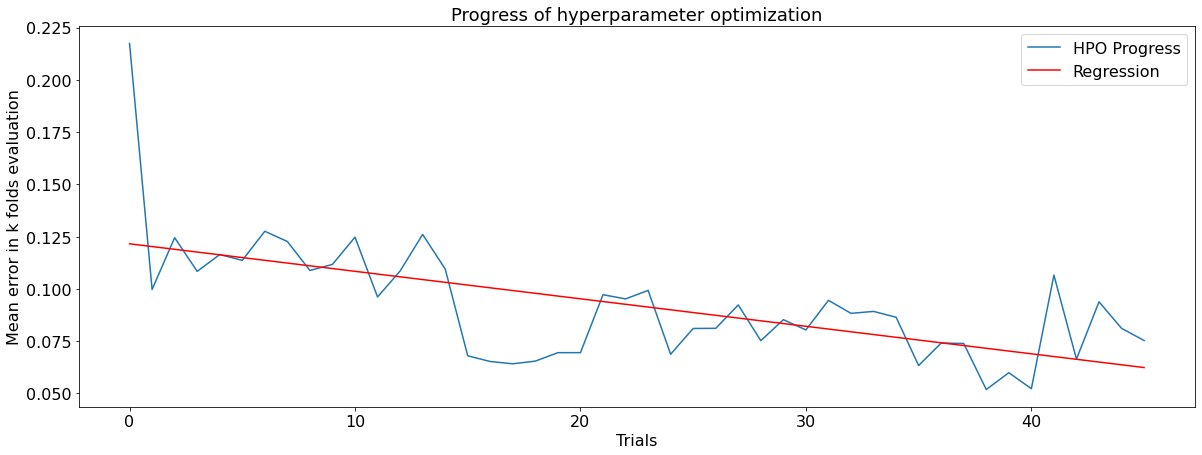

HPO Progess of cl_m-tft_out-48_freq-1h_wind_seven
Improvement per Trial: 0.0017087388659976395


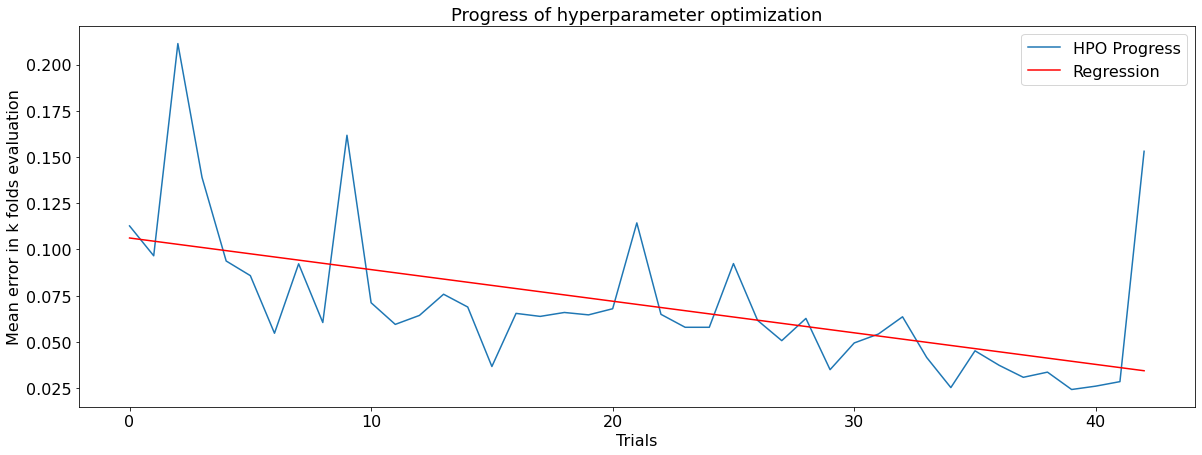

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_00164
Improvement per Trial: 9.60344130100648e-05


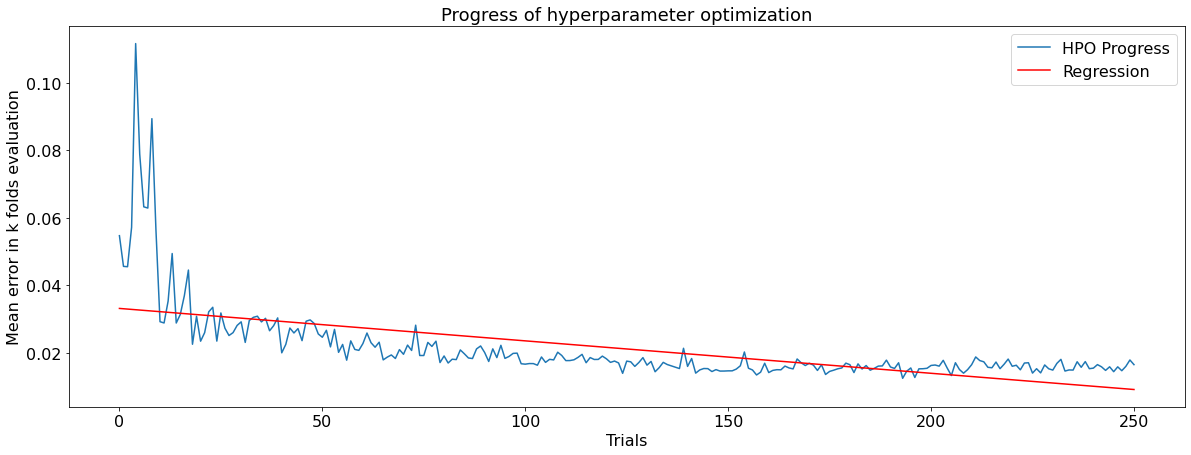

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_02638
Improvement per Trial: 0.00030169470191406135


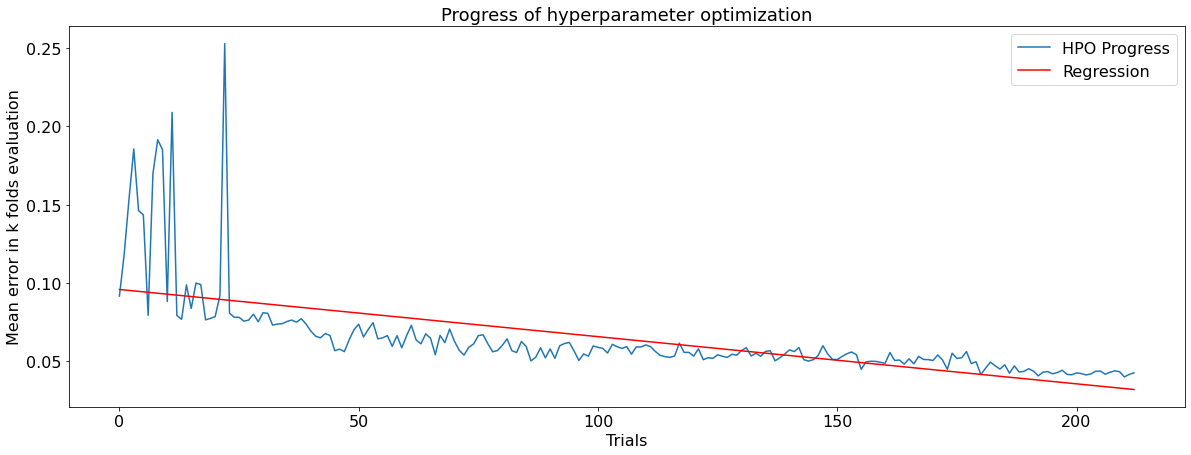

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_seven
Improvement per Trial: 0.0018456264901618978


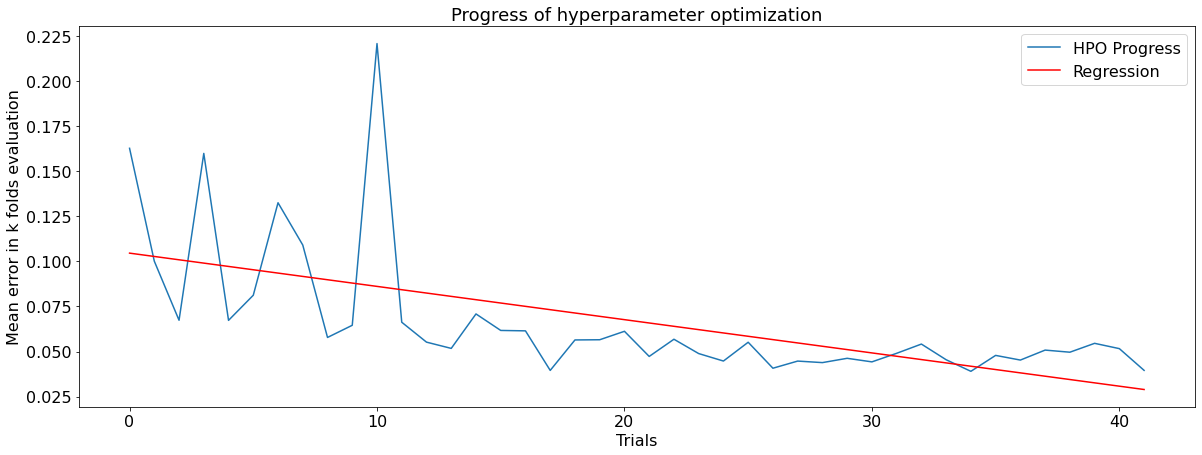

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_02932
Improvement per Trial: 0.00036821545138028555


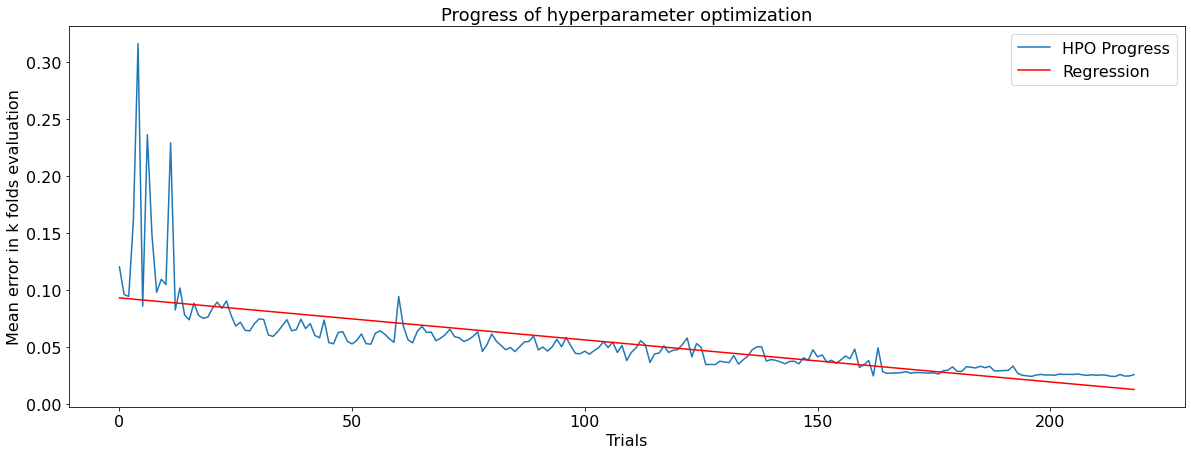

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_03362
Improvement per Trial: 0.00047130635740228664


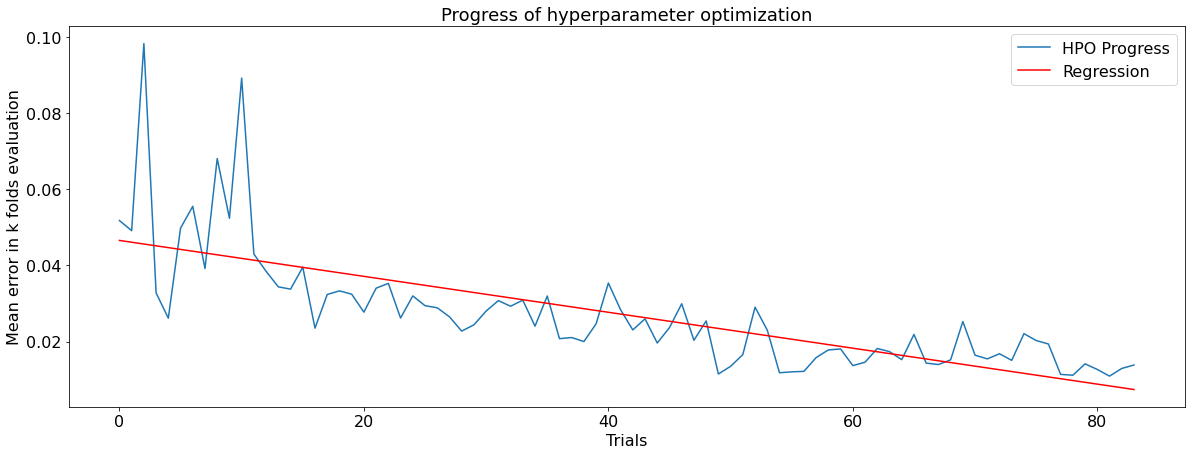

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_03631
Improvement per Trial: 0.0007663575626791802


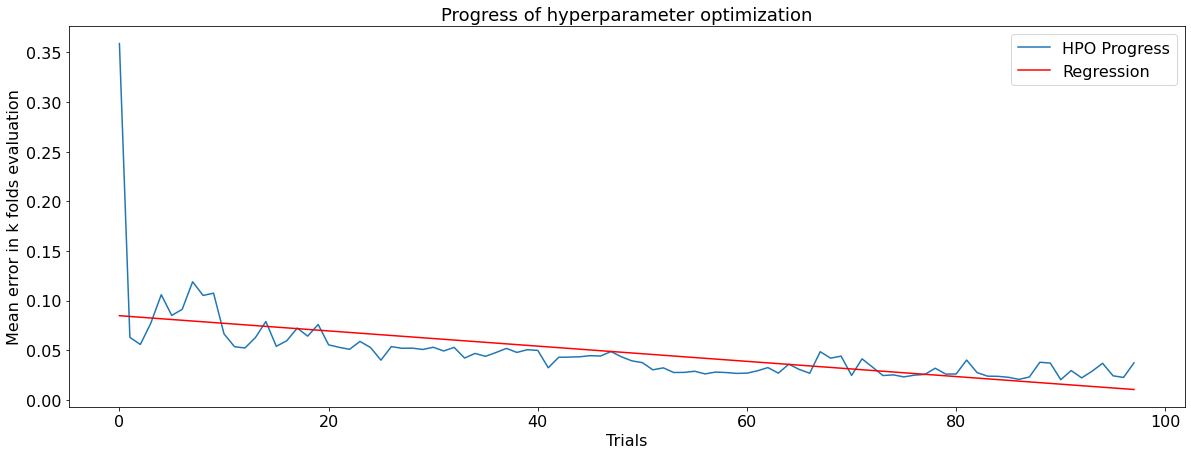

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_06163
Improvement per Trial: 0.00043510404785119096


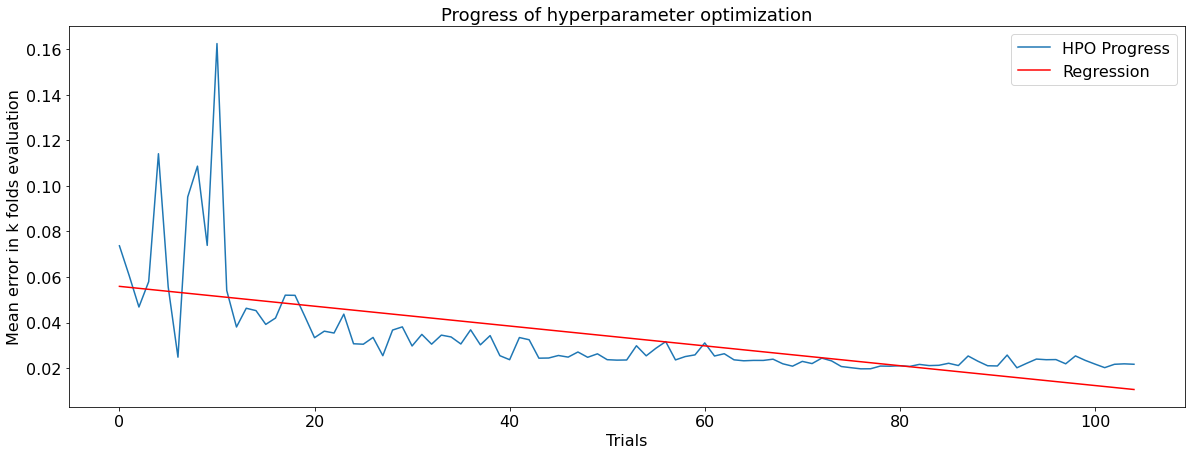

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_07370
Improvement per Trial: 0.0005166702238293088


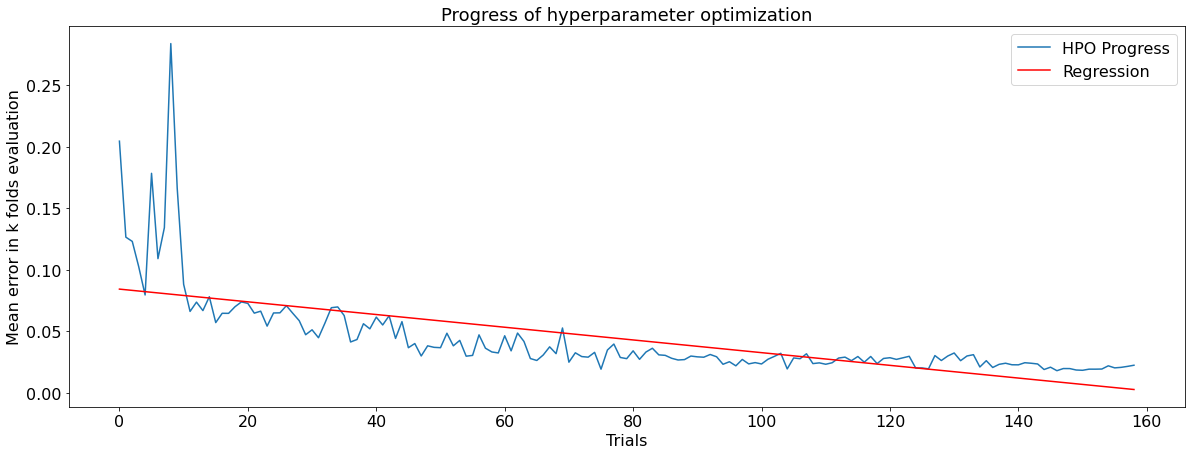

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind_07374
Improvement per Trial: 0.0005448514225908175


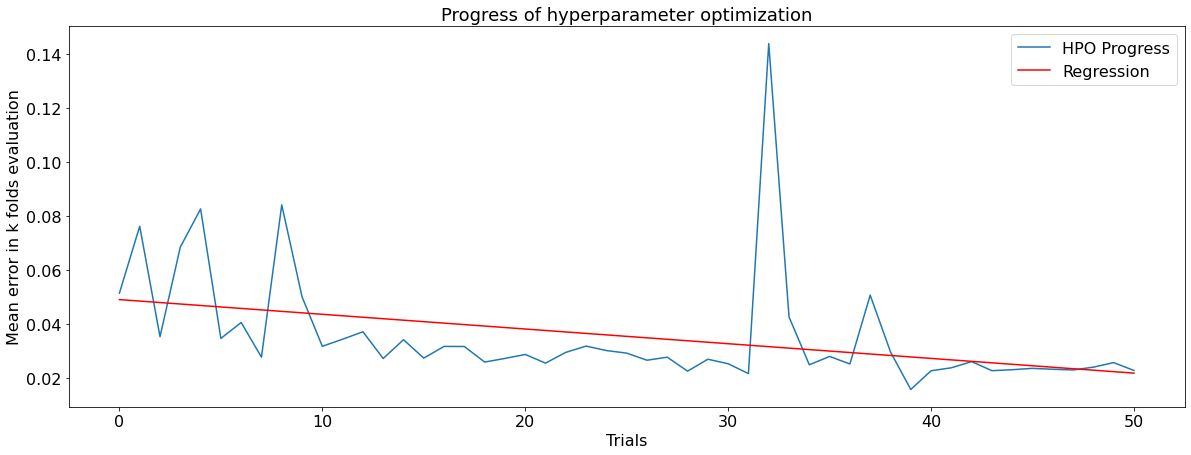

HPO Progess of cl_m-tcn-gru_out-48_freq-1h_wind


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

In [7]:
for study in studies:
    print(f'HPO Progess of {study.study_name}')
    trials = [trial for trial in study.trials if trial.value is not None and trial.state == optuna.trial.TrialState.COMPLETE]
    sorted_trials = sorted(trials, key=lambda x: x.value)
    sorted_by_number = sorted(trials, key=lambda x: x.number)
    progress = [trial.values for trial in sorted_by_number]
    x = np.arange(len(progress)).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(x, progress)
    y_pred = lr.predict(x)
    plt.figure(figsize=(20,7))
    print('Improvement per Trial:', lr.coef_[0][0]*-1)
    plt.plot(progress, label='HPO Progress')
    plt.plot(y_pred, 'r-', label='Regression')
    plt.title('Progress of hyperparameter optimization', fontsize=font_size+2)
    plt.xlabel('Trials', fontsize=font_size)
    plt.ylabel('Mean error in k folds evaluation', fontsize=font_size)
    ax = plt.gca()  # Get current axes
    ax.tick_params(axis='x', labelsize=font_size)  # Schriftgröße für x-Achsenmarkierungen
    ax.tick_params(axis='y', labelsize=font_size)
    #plt.yticks(np.arange(0,1,0.1))
    #plt.ylim(0,0.6)
    plt.legend(fontsize=font_size)
    plt.show()